<hr style="height:2px;">

# Demo: Phase Retrieval

In this tutorial we will use Pycro-Manager to easily collect a quantitative phase image of a sample! We will be using the [Transport of Intensity Equation (TIE)](https://en.wikipedia.org/wiki/Transport-of-intensity_equation)  to retrieve quantitative phase from a z-stack aquired by pycromanager on your microscope.

Please install [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/setup.html) locally before running this Colab notebook.

<hr style="height:2px;">

## Part 1: Setup

If you have not yet, install Pycro-Manager:   
```
pip install pycromanager
```
Make sure you have NumPy, SciPy, TensorFlow (version >=2.3), and TensorFlow Probability installed before preceding.
Run the following block (it's quite long! Don't worry!):

In [1]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
# import tensorflow_probability as tfp
from scipy.optimize import fsolve
from scipy.io import loadmat

test_path = 'phase_rec_GUI/datasets/moustache_man_stack.mat'


def GP_TIE(Ividmeas, z_vec, lambd, ps, zfocus, Nsl, eps1, eps2, reflect):

    RePhase1 = RunGaussianProcess(Ividmeas, zfocus, z_vec, lambd, ps, Nsl, eps1, eps2, reflect)
    RePhase1 = RePhase1 / np.mean(Ividmeas)
    return RePhase1

def RunGaussianProcess(Ividmeas,zfocus,z_vec,lambd,ps,Nsl,eps1,eps2,reflect):

    (Nx, Ny, Nz) = Ividmeas.shape
    I0 = Ividmeas[:,:,zfocus]
    zfocus = z_vec[zfocus]
    freqs = CalFrequency(Ividmeas[:,:,0], lambd, ps, 1)
    max_freq = np.max(freqs)
    max_freq = np.sqrt(max_freq / (lambd / 2))
    freq_cutoff = np.linspace(0,1,Nsl) * max_freq
    freq_cutoff = freq_cutoff ** 2 * lambd / 2

    SigmafStack = np.zeros((Nsl,1))
    SigmanStack = np.zeros((Nsl,1))
    SigmalStack = np.zeros((Nsl,1))
    freq_to_sc = np.linspace(1.2,1.1,Nsl)
    p = Nz / (np.max(z_vec) - np.min(z_vec))

    for k in range(Nsl):
        Sigman = 10.0**-9
        Sigmaf = 1.0

        f1 = freq_cutoff[k]
        sc = f1 * freq_to_sc[k]
        a = sc**2 * 2 * np.pi**2
        b = np.log((p * (2*np.pi)**0.5)/Sigman)
        def fu2(x):
            return a*np.exp(x)-0.5*x-b
        x = fsolve(fu2, 5)
        Sigmal = np.exp(x)

        SigmafStack[k] = Sigmaf
        SigmanStack[k] = Sigman
        SigmalStack[k] = Sigmal

    dIdzStack = np.zeros((Nx,Ny,Nsl))
    CoeffStack = np.zeros((Nz,Nsl))
    Coeff2Stack = np.zeros((Nz,Nsl))
    for k in range(Nsl):
        Sigmal = SigmalStack[k]
        Sigman = SigmanStack[k]
        Sigmaf = SigmafStack[k]
        dIdz, Coeff, Coeff2 = GPRegression(Ividmeas, zfocus, z_vec, Sigmaf, Sigmal, Sigman)
        dIdzStack[:,:,k] = 2*np.pi/lambd*ps**2*dIdz
        CoeffStack[:,k] = Coeff
        Coeff2Stack[:,k] = Coeff2

    dIdzC = CombinePhase(dIdzStack, freq_cutoff, freqs, CoeffStack, Coeff2Stack)
    ### poisson solver

    Del2_Psi_xy = (-2*np.pi/lambd) * dIdzC
    N = dIdzC.shape[0]
    Psi_xy = poisson_solve(Del2_Psi_xy, ps, eps1, 0, reflect)

    Grad_Psi_x, Grad_Psi_y = np.gradient(Psi_xy/ps)
    Grad_Psi_x = Grad_Psi_x / (I0 + eps2)
    Grad_Psi_y = Grad_Psi_y / (I0 + eps2)
    grad2x, _ = np.gradient(Grad_Psi_x/ps)
    _, grad2y = np.gradient(Grad_Psi_y/ps)
    Del2_Psi_xy = grad2x + grad2y
    Phi_xy = poisson_solve(Del2_Psi_xy, ps, eps1, 1, reflect)
    dcval = (np.sum(Phi_xy[:,0]) + np.sum(Phi_xy[0,:]) + np.sum(Phi_xy[N-1,:]) + np.sum(Phi_xy[:,N-1]))/(4*N)
    RePhase = -1 * (Phi_xy - dcval)
    return RePhase

def CalFrequency(img, lambd, ps, dz):
    (nx, ny) = img.shape
    dfx = 1/nx/ps
    dfy = 1/ny/ps
    (Kxdown, Kydown) = np.mgrid[-nx//2:nx//2,-ny//2:ny//2]
    Kxdown = Kxdown * dfx
    Kydown = Kydown * dfy
    freqs = lambd * np.pi * (Kxdown ** 2 + Kydown ** 2)
    freqs = freqs * dz / (2 * np.pi)
    return freqs

def CombinePhase(dIdzStack, Frq_cutoff, freqs, CoeffStack, Coeff2Stack):
    def F(x):
        return fft.ifftshift(fft.fft2(fft.fftshift(x)))

    def Ft(x):
        return fft.ifftshift(fft.ifft2(fft.fftshift(x)))

    Nx, Ny, Nsl = dIdzStack.shape
    dIdzC_fft = np.zeros((Nx,Ny))
    Maskf = np.zeros((Nx,Ny))
    f0 = 0
    f1 = 1

    for k in range(Nsl):
        dIdz = dIdzStack[:,:,k]
        dIdz_fft = F(dIdz)
        f1 = Frq_cutoff[k]
        Maskf = np.zeros((Nx,Ny))
        Maskf[np.argwhere((freqs<=f1) & (freqs>f0))] = 1
        f0 = f1
        dIdzC_fft = dIdzC_fft + (dIdz_fft * Maskf)

    return np.real(Ft(dIdzC_fft))

def poisson_solve(func, ps, eps, symm, reflect):
    N = len(func)

    if reflect != 0:
        N = N * 2
        func = np.hstack([func, np.fliplr(func)])
        func = np.vstack([func, np.flipud(func)])

    wx = 2 * np.pi * np.arange(0,N,1)/N
    fx = 1/(2 * np.pi * ps) * (wx - np.pi * (1 - N % 2 / N))
    [Fx, Fy] = np.meshgrid(fx, fx)
    func_ft = np.fft.fftshift(np.fft.fft2(func))

    Psi_ft = func_ft / (-4 * np.pi**2 * (Fx**2 + Fy**2 + eps))
    if (symm):
        Psi_xy = np.fft.irfft2(np.fft.ifftshift(Psi_ft)[:,0:N//2+1])
    else:
        Psi_xy = np.fft.ifft2(np.fft.ifftshift(Psi_ft))

    if reflect != 0:
        N = N//2
        Psi_xy = np.array(Psi_xy)[:N,:N]
    return Psi_xy

def mrdivide(A, B):
    # Solves A / B or xA = B
    return A.dot(np.linalg.pinv(B))


def GPRegression(Ividmeas, zfocus, z, Sigmaf, Sigmal, Sigman):
    Nx, Ny, Nz = Ividmeas.shape
    ones = np.ones((Nz,1))
    KZ = ones.dot(z.T) - z.dot(ones.T)
    K = Sigmaf * (np.exp(-1/2/Sigmal*(KZ**2)))
    L = np.linalg.cholesky(K+(Sigman*np.eye(Nz))).T #why multiplying by I
    z2 = zfocus

    Nz2 = len(z2)
    ones2 = np.ones((Nz2,1))
    KZ2 = ones * (z2.T) - z * (ones2.T)

    D = Sigmaf * (np.exp((-1/2/Sigmal)*(KZ2**2))) / -Sigmal * KZ2
    Coeff = mrdivide(mrdivide(D.T, L), L.T)[0]
    D2 = Sigmaf * (np.exp((-1/2/Sigmal)*(KZ2**2)))
    Coeff2 = mrdivide(mrdivide(D2.T, L), L.T)
    dIdz = np.zeros((Nx,Ny))
    for k in range(Nz):
        dIdz = dIdz + Ividmeas[:,:,k].dot(Coeff[k])
    return dIdz, Coeff, Coeff2

# def main():
#     data = loadmat(test_path)
#     Ividmeas = data['Istack']
#     z_vec = data['zvec']
#     if z_vec.shape[0] == 1:
#         z_vec = z_vec.T

#     lambd = data['lambda'][0][0]
#     ps = data['ps']
#     zfocus = 1
#     Nsl = 100
#     eps1 = 1
#     eps2 = 1
#     reflect = False

#     phase = GP_TIE(Ividmeas, z_vec, lambd, ps, zfocus, Nsl, eps1, eps2, reflect)
#     plt.imshow(phase)
#     plt.show()

# if __name__ == '__main__':
#     main()

<hr style="height:2px;">

## Part 2: Collect a Z-Stack of your sample

First verify you have a working installation of [Pycro-Manager](https://pycro-manager.readthedocs.io/en/latest/setup.html). Open Micro-Manager, select tools-options, and check the box that says Run server on port 4827 (you only need to do this once). Run:

In [2]:
from pycromanager import Acquisition, multi_d_acquisition_events, Dataset

We will be using [aquisition events](https://pycro-manager.readthedocs.io/en/latest/acq_intro.html), an extremely useful feature of Pycro-Manager that allows you to create sets of hardware postitions and images to collect images.
Let's create an aquisition event that will collect a z-stack of the sample we have staged on our microscope right now. The following code will create the [aquisition event](https://pycro-manager.readthedocs.io/en/latest/apis.html?highlight=multi_d_aq#pycromanager.multi_d_acquisition_events) and initiate collection of the z-stack. Make sure your microscope is ready, and specify the filepath you want to store the images in.

In [3]:
events = []
if __name__ == '__main__':
    with Acquisition(directory=r'C:\Users\Ryan\Desktop\Imaging\test_folder', name='tie_acq') as acq:
        events = multi_d_acquisition_events(z_start=0, z_end=3, z_step=1)  # in micrometers
        acq.acquire(events)

In [12]:
data = Dataset(dataset_path=r'C:\Users\Ryan\Desktop\Imaging\test_folder\tie_acq_22').as_array()  # _17 could be another number!
Ividmeas = np.asarray(data) # as_arry() returns a Dask array, but we would like to work with np arrays
z_vec = np.array([[i['z'] for i in events]])

Dataset opened
Adding data chunk 3 of 3Stacking tiles
Dask array opened


In [16]:
print(data)
print(events)
print(np.shape(Ividmeas))
print(Ividmeas)
print(z_vec)

dask.array<stack, shape=(3, 512, 512), dtype=uint16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
[{'axes': {'z': 0}, 'z': 0}, {'axes': {'z': 1}, 'z': 1}, {'axes': {'z': 2}, 'z': 2}]
(3, 512, 512)
[[[3276 3339 3402 ... 3087 3150 3213]
  [3284 3347 3410 ... 3095 3158 3221]
  [3292 3355 3418 ... 3103 3166 3229]
  ...
  [5846 5846 5844 ... 5837 5842 5845]
  [5846 5846 5844 ... 5838 5842 5845]
  [5846 5846 5843 ... 5839 5843 5845]]

 [[5093 5138 5180 ... 4955 5002 5048]
  [5099 5143 5186 ... 4961 5008 5054]
  [5105 5148 5191 ... 4967 5014 5060]
  ...
  [5110 5065 5020 ... 5238 5196 5154]
  [5105 5060 5014 ... 5232 5191 5148]
  [5099 5054 5008 ... 5227 5186 5143]]

 [[5036 5035 5033 ... 5030 5033 5035]
  [5036 5035 5033 ... 5030 5033 5035]
  [5036 5035 5032 ... 5031 5034 5035]
  ...
  [2842 2788 2734 ... 3005 2951 2897]
  [2836 2781 2727 ... 2998 2944 2890]
  [2829 2774 2720 ... 2992 2937 2883]]]
[[0]
 [1]
 [2]]


Our images are now in data! Let's apply TIE and see the results:

In [15]:
if z_vec.shape[0] == 1:
    z_vec = z_vec.T
    print('transformed')

transformed


In [17]:
lambd = data['lambda'][0][0]
ps = data['ps']
zfocus = 1
Nsl = 50
eps1 = 1
eps2 = 1
reflect = False

KeyError: 'There are no fields in dtype uint16.'

In [8]:
test_path = r'C:\Users\Ryan\Downloads\moustache_man_stack.mat'

data = loadmat(test_path)

In [10]:
Ividmeas = data['Istack']   # 512x512x3 array

In [9]:
z_vec = data['zvec']
if z_vec.shape[0] == 1:
    z_vec = z_vec.T
print(z_vec)

[[-2.e-05]
 [ 0.e+00]
 [ 2.e-05]]


In [ ]:
print(data['lambda'])

In [11]:
lambd = data['lambda'][0][0]
ps = data['ps']
zfocus = 1
Nsl = 50
eps1 = 1
eps2 = 1
reflect = False

phase:  (512, 512)
time:  40.64507055282593


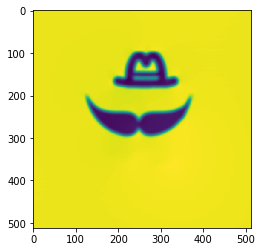

In [12]:
gptie = GP_TIE()
# print("loading data")
start = time.time()
phase = gptie(Ividmeas, z_vec, lambd, ps, zfocus, Nsl, eps1, eps2, reflect).numpy()
end = time.time()
print("phase: ", phase.shape)
print("time: ", end - start)
plt.imshow(phase)
plt.show()

In [ ]:
mou = Ividmeas[:,:,0]
plt.imshow(mou)
plt.show()

In [ ]:
mou = Ividmeas[:,:,1]
plt.imshow(mou)
plt.show()

In [ ]:
mou = Ividmeas[:,:,2]
plt.imshow(mou)
plt.show()